# A notebook for test and debug some python code

### To do
* Create a conda env [X]
*     Im having a error [X] (resolvi usando pip no ambiente)
*   ERRO TRANSFORM TORCHVISION
* Selecionar e colocar arquiteturas [X]
* unet[X]
* ddpm
* cyclogan 
* vae
* vit [X]
* Colocar funcoes de perda da tabela
* Colocar todas as metricas

### import the utils libs

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models
import torchvision.transforms as transforms
#from torchvision import transforms 
import numpy as np
from PIL import Image



In [3]:
%pip install torchinfo kornia lpips

In [7]:
import kornia
print(kornia.__version__)

0.7.1


In [11]:

import torchinfo as tinf

In [12]:
# tinf.summary?

Signature:
tinf.summary(
    model: 'nn.Module',
    input_size: 'INPUT_SIZE_TYPE | None' = None,
    input_data: 'INPUT_DATA_TYPE | None' = None,
    batch_dim: 'int | None' = None,
    cache_forward_pass: 'bool | None' = None,
    col_names: 'Iterable[str] | None' = None,
    col_width: 'int' = 25,
    depth: 'int' = 3,
    device: 'torch.device | str | None' = None,
    dtypes: 'list[torch.dtype] | None' = None,
    mode: 'str | None' = None,
    row_settings: 'Iterable[str] | None' = None,
    verbose: 'int | None' = None,
    **kwargs: 'Any',
) -> 'ModelStatistics'
Docstring:
Summarize the given PyTorch model. Summarized information includes:
    1) Layer names,
    2) input/output shapes,
    3) kernel shape,
    4) # of parameters,
    5) # of operations (Mult-Adds),
    6) whether layer is trainable

NOTE: If neither input_data or input_size are provided, no forward pass through the
network is performed, and the provided model information is limited to layer names.

Args:
    m

In [14]:
# tinf.summary?

Signature:
tinf.summary(
    model: 'nn.Module',
    input_size: 'INPUT_SIZE_TYPE | None' = None,
    input_data: 'INPUT_DATA_TYPE | None' = None,
    batch_dim: 'int | None' = None,
    cache_forward_pass: 'bool | None' = None,
    col_names: 'Iterable[str] | None' = None,
    col_width: 'int' = 25,
    depth: 'int' = 3,
    device: 'torch.device | str | None' = None,
    dtypes: 'list[torch.dtype] | None' = None,
    mode: 'str | None' = None,
    row_settings: 'Iterable[str] | None' = None,
    verbose: 'int | None' = None,
    **kwargs: 'Any',
) -> 'ModelStatistics'
Docstring:
Summarize the given PyTorch model. Summarized information includes:
    1) Layer names,
    2) input/output shapes,
    3) kernel shape,
    4) # of parameters,
    5) # of operations (Mult-Adds),
    6) whether layer is trainable

NOTE: If neither input_data or input_size are provided, no forward pass through the
network is performed, and the provided model information is limited to layer names.

Args:
    m

## Archtectures


### U-net

In [4]:


class DoubleConv(nn.Module):
    """
    Bloco de duas convoluções 3x3 seguidas de ReLU.
    """
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    """
    Implementação da arquitetura U-Net adaptada para geração de imagens.
    """
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels

        # Encoder
        self.down1 = DoubleConv(in_channels, 64)
        self.down2 = DoubleConv(64, 128)
        self.down3 = DoubleConv(128, 256)
        self.down4 = DoubleConv(256, 512)
        self.down5 = DoubleConv(512, 1024)

        # Max-pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Decoder
        self.up1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv_up1 = DoubleConv(1024, 512)
        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv_up2 = DoubleConv(512, 256)
        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv_up3 = DoubleConv(256, 128)
        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv_up4 = DoubleConv(128, 64)

        # Final convolution
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        d1 = self.down1(x)
        d2 = self.down2(self.pool(d1))
        d3 = self.down3(self.pool(d2))
        d4 = self.down4(self.pool(d3))
        d5 = self.down5(self.pool(d4))

        # Decoder
        u1 = self.up1(d5)
        u1 = torch.cat((u1, d4), dim=1)
        u1 = self.conv_up1(u1)
        u2 = self.up2(u1)
        u2 = torch.cat((u2, d3), dim=1)
        u2 = self.conv_up2(u2)
        u3 = self.up3(u2)
        u3 = torch.cat((u3, d2), dim=1)
        u3 = self.conv_up3(u3)
        u4 = self.up4(u3)
        u4 = torch.cat((u4, d1), dim=1)
        u4 = self.conv_up4(u4)

        return self.final_conv(u4)

if __name__ == "__main__":
    # Definindo o dispositivo (GPU se disponível)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Inicializando a U-Net
    in_channels = 3  # Por exemplo, RGB
    out_channels = 3  # Saída de imagem RGB
    model = UNet(in_channels, out_channels).to(device)

    # Exemplo de entrada
    x = torch.randn(1, in_channels, 256, 256).to(device)  # Batch size 1, 256x256 imagem
    output = model(x)

    print(x.shape, output.shape)  # Deve ser (1, out_channels, 256, 256)
     # Plotando a arquitetura da rede
    


torch.Size([1, 3, 256, 256]) torch.Size([1, 3, 256, 256])


### Torchinfo

In [5]:

model_stats = tinf.summary(model, (1, 3, 256, 256), verbose=0)
summary_str = str(model_stats)
# summary_str contains the string representation of the summary!
print(model_stats)

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [1, 3, 256, 256]          --
├─DoubleConv: 1-1                        [1, 64, 256, 256]         --
│    └─Sequential: 2-1                   [1, 64, 256, 256]         --
│    │    └─Conv2d: 3-1                  [1, 64, 256, 256]         1,792
│    │    └─BatchNorm2d: 3-2             [1, 64, 256, 256]         128
│    │    └─ReLU: 3-3                    [1, 64, 256, 256]         --
│    │    └─Conv2d: 3-4                  [1, 64, 256, 256]         36,928
│    │    └─BatchNorm2d: 3-5             [1, 64, 256, 256]         128
│    │    └─ReLU: 3-6                    [1, 64, 256, 256]         --
├─MaxPool2d: 1-2                         [1, 64, 128, 128]         --
├─DoubleConv: 1-3                        [1, 128, 128, 128]        --
│    └─Sequential: 2-2                   [1, 128, 128, 128]        --
│    │    └─Conv2d: 3-7                  [1, 128, 128, 128]        73,856
│ 

### Torchviz

In [22]:
# try:
#         y = model(torch.randn(1, in_channels, 256, 256).to(device))
#         tv.make_dot(y, params=dict(list(model.named_parameters()))).render("unet_architecture", format="png")
        
#         #plot.format = 'png'
        
#         print("Arquitetura da U-Net plotada com sucesso.")
# except ImportError:
#         print("Para plotar a arquitetura, instale o pacote torchviz.")


Arquitetura da U-Net plotada com sucesso.


### Torchsummary

In [11]:
# summary(model, x,depth=1, dtypes=[torch.long],branching=False,verbose=1, col_width=16)

TypeError: summary() got an unexpected keyword argument 'depth'

In [8]:

class DoubleConv(nn.Module):
    """
    Bloco de duas convoluções 3x3 seguidas de ReLU.
    Permite a parametrização do uso de BatchNorm.
    """
    def __init__(self, in_channels, out_channels, use_batch_norm=True):
        super(DoubleConv, self).__init__()
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        ]
        if use_batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))

        layers.extend([
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        ])
        if use_batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        
        self.double_conv = nn.Sequential(*layers)

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    """
    Implementação da arquitetura U-Net parametrizável para geração de imagens.
    Permite a parametrização do número de blocos de convolução e o uso de BatchNorm.
    """
    def __init__(self, in_channels, out_channels, base_filters=64, num_layers=5, use_batch_norm=True):
        super(UNet, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.base_filters = base_filters
        self.num_layers = num_layers
        self.use_batch_norm = use_batch_norm

        # Encoder
        self.encoder_layers = nn.ModuleList()
        filters = base_filters
        
        for i in range(num_layers-1):
            self.encoder_layers.append(DoubleConv(in_channels, filters, use_batch_norm))
            in_channels = filters
            filters *= 2
        
        # Max-pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck
        self.bottleneck = DoubleConv(filters // 2, filters, use_batch_norm)

        # Decoder
        self.up_layers = nn.ModuleList()
        self.up_convs = nn.ModuleList()
        
        
        for i in range(num_layers-1, 0, -1):#range(num_layers-1, 0, -1)
            filters //= 2
            self.up_layers.append(nn.ConvTranspose2d(filters * 2, filters, kernel_size=2, stride=2))
            self.up_convs.append(DoubleConv(filters * 2, filters , use_batch_norm))
            

        # Final convolution
        
        self.final_conv = nn.Conv2d(base_filters, out_channels, kernel_size=1)
    def see_model(self):
        print(f"""
        encoder: {self.encoder_layers}
        pool: {self.pool}
        botleneck: {self.bottleneck}
        up laeyers: {self.up_layers}
        up_convs: {self.up_convs}
        final conv: {self.final_conv}""")

    def forward(self, x):
        # Encoder
        encoder_results = []
        for layer in self.encoder_layers:
            x = layer(x)
            encoder_results.append(x)
            x = self.pool(x)

        # Bottleneck
        x = self.bottleneck(x)

        # Decoder
        for i, (up, conv) in enumerate(zip(self.up_layers, self.up_convs)):
            x = up(x)
            x = torch.cat((x, encoder_results[-(i+1)]), dim=1)
            x = conv(x)

        return self.final_conv(x)

def standardize_image(image):
    """
    Função para padronizar as imagens de entrada.
    """
    mean = image.mean()
    std = image.std()
    return (image - mean) / std

if __name__ == "__main__":
    # Definindo o dispositivo (GPU se disponível)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Inicializando a U-Net parametrizável
    in_channels = 3  # Por exemplo, RGB
    out_channels = 3  # Saída de imagem RGB
    base_filters = 64
    num_layers = 4
    use_batch_norm = True
    model = UNet(in_channels, out_channels, base_filters, num_layers, use_batch_norm).to(device)
    #model.see_model()

    # Exibindo a arquitetura da rede
    #summary(model, input_size=(in_channels, 256, 256))

    # Exemplo de entrada
    x = torch.randn(1, in_channels, 256, 256).to(device)  # Batch size 1, 256x256 imagem
    # x = standardize_image(x)
    output = model(x)

    print(output.shape)  # Deve ser (1, out_channels, 256, 256)


torch.Size([1, 3, 256, 256])


In [ ]:

# # Plotando a arquitetura da rede
# try:

#     y = model(torch.randn(1, in_channels, 256, 256).to(device))
#     tv.make_dot(y, params=dict(list(model.named_parameters()))).render("unet_architecture_2", format="png")
#     print("Arquitetura da U-Net plotada com sucesso.")
# except ImportError:
#     print("Para plotar a arquitetura, instale o pacote torchviz.")


In [13]:
tinf.summary(model, x,depth=1, dtypes=[torch.long],branching=False,verbose=1, col_width=16)

TypeError: Input_size is not a recognized type. Please ensure input_size is valid.
For multiple inputs to the network, ensure input_size is a list of tuple sizes. If you are having trouble here, please submit a GitHub issue.

### Limpa memoria CUDA

In [13]:
import gc

# Verifique a memória alocada e reservada
print(f'Memória alocada: {torch.cuda.memory_allocated()} bytes')
print(f'Memória reservada: {torch.cuda.memory_reserved()} bytes')

# Force a coleta de lixo para liberar a memória imediatamente
gc.collect()

# Libere o cache de memória do PyTorch
torch.cuda.empty_cache()

# Verifique a memória alocada e reservada
print(f'Memória alocada: {torch.cuda.memory_allocated()} bytes')
print(f'Memória reservada: {torch.cuda.memory_reserved()} bytes')

print(f"Memoria limpa")

Memória alocada: 0 bytes
Memória reservada: 0 bytes
Memória alocada: 0 bytes
Memória reservada: 0 bytes
Memoria limpa


### DDPM

### CycleGAN


In [26]:
# import os
# if not os.path.isdir("pytorch-CycleGAN-and-pix2pix"):
#     !git clone https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix.git
# os.chdir("pytorch-CycleGAN-and-pix2pix")
# !pip install -r requirements.txt 
# !ls

CycleGAN.ipynb	docs		 LICENSE  pix2pix.ipynb     scripts   util
data		environment.yml  models   README.md	    test.py
datasets	imgs		 options  requirements.txt  train.py


In [ ]:
#Falta aprender a resgatar o modelo

### VAE

In [34]:
!ls

loss	    pytorch-CycleGAN-and-pix2pix  unet_architecture_2.png
Losses.yml  README.md			  unet_architecture.png
main.py     src				  vit_architecture.png
metrics     unet_architecture		  work.ipynb
models	    unet_architecture_2


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim

# Encoder parametrizável com BatchNorm
class Encoder(nn.Module):
    def __init__(self, input_channels, hidden_dims, latent_dim):
        super(Encoder, self).__init__()
        
        # Inicializa uma lista para armazenar as camadas da rede
        modules = []
        
        # Adiciona camadas de convolução e batch normalization conforme especificado em hidden_dims
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(input_channels, h_dim, kernel_size=4, stride=2, padding=1),
                    nn.BatchNorm2d(h_dim),
                    nn.ReLU()
                )
            )
            input_channels = h_dim
        
        # Define as camadas finais para calcular mu e logvar
        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1] * 16 * 16, latent_dim)  # Supondo entrada de 256x256
        self.fc_logvar = nn.Linear(hidden_dims[-1] * 16 * 16, latent_dim)
    
    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

# Decoder parametrizável com BatchNorm
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dims, output_channels):
        super(Decoder, self).__init__()
        
        # Inicializa uma lista para armazenar as camadas da rede
        modules = []
        
        # Primeira camada completamente conectada para expandir a representação latente
        self.fc = nn.Linear(latent_dim, hidden_dims[-1] * 16 * 16)
        
        # Adiciona camadas de convolução transposta e batch normalization conforme especificado em hidden_dims
        hidden_dims.reverse()
        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=4,
                                       stride=2,
                                       padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.ReLU()
                )
            )
        
        # Camada final para reconstrução da imagem
        modules.append(
            nn.Sequential(
                nn.ConvTranspose2d(hidden_dims[-1],
                                   output_channels,
                                   kernel_size=4,
                                   stride=2,
                                   padding=1),
                nn.Sigmoid()
            )
        )
        
        self.decoder = nn.Sequential(*modules)
    
    def forward(self, z):
        x = torch.relu(self.fc(z))
        x = x.view(x.size(0), -1, 16, 16)
        x = self.decoder(x)
        return x

# Definição do VAE parametrizável
class VAE(nn.Module):
    def __init__(self, input_channels, hidden_dims, latent_dim, output_channels):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_channels, hidden_dims, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dims, output_channels)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

# Configuração de parâmetros
latent_dim = 16
hidden_dims = [32, 64, 128, 256]
input_channels = 3
output_channels = 3

# Inicialização do modelo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VAE(input_channels=input_channels, hidden_dims=hidden_dims, latent_dim=latent_dim, output_channels=output_channels).to(device)

# Teste com tensor randômico
model.eval()
with torch.no_grad():
    # Gera um tensor randômico com formato (1, 3, 256, 256)
    random_tensor = torch.randn(1, 3, 256, 256).to(device)
    
    # Passa o tensor randômico pelo encoder para obter mu e logvar
    mu, logvar = model.encoder(random_tensor)
    
    # Reamostragem para obter o vetor latente z
    z = model.reparameterize(mu, logvar)
    
    # Passa o vetor latente pelo decoder para gerar a imagem reconstruída
    generated_image, _, _ = model(random_tensor)
    
    print("Generated Image Shape:", generated_image.shape)  # Esperado: (1, 3, 256, 256)


Generated Image Shape: torch.Size([1, 3, 256, 256])


In [19]:
tinf.summary(model, (1,3,256,256),depth=4)

Layer (type:depth-idx)                        Output Shape              Param #
VAE                                           [1, 3, 256, 256]          --
├─Encoder: 1-1                                [1, 16]                   --
│    └─Sequential: 2-1                        [1, 256, 16, 16]          --
│    │    └─Sequential: 3-1                   [1, 32, 128, 128]         --
│    │    │    └─Conv2d: 4-1                  [1, 32, 128, 128]         1,568
│    │    │    └─BatchNorm2d: 4-2             [1, 32, 128, 128]         64
│    │    │    └─ReLU: 4-3                    [1, 32, 128, 128]         --
│    │    └─Sequential: 3-2                   [1, 64, 64, 64]           --
│    │    │    └─Conv2d: 4-4                  [1, 64, 64, 64]           32,832
│    │    │    └─BatchNorm2d: 4-5             [1, 64, 64, 64]           128
│    │    │    └─ReLU: 4-6                    [1, 64, 64, 64]           --
│    │    └─Sequential: 3-3                   [1, 128, 32, 32]          --
│    │    │ 

### Vit

In [21]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, embed_dim)
        )
        self.norm2 = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        attn_output, _ = self.attn(x, x, x)
        x = x + self.dropout(attn_output)
        x = self.norm1(x)
        mlp_output = self.mlp(x)
        x = x + self.dropout(mlp_output)
        x = self.norm2(x)
        return x


In [22]:
class ImageEnhancerTransformer(nn.Module):
    def __init__(self, image_size=256, patch_size=16, num_channels=3, embed_dim=512, num_heads=8, mlp_dim=1024, num_layers=6, dropout=0.1):
        super(ImageEnhancerTransformer, self).__init__()
        self.image_size = image_size
        self.patch_size = patch_size
        self.num_patches = (image_size // patch_size) ** 2
        self.patch_dim = num_channels * patch_size * patch_size
        self.embed_dim = embed_dim

        self.patch_embeddings = nn.Linear(self.patch_dim, embed_dim)
        self.position_embeddings = nn.Parameter(torch.zeros(1, self.num_patches, embed_dim))

        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, mlp_dim, dropout) for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.fc = nn.Linear(embed_dim, self.patch_dim)

    def forward(self, x):
        batch_size = x.size(0)
        x = self._to_patches(x)
        x = self.patch_embeddings(x) + self.position_embeddings

        for block in self.transformer_blocks:
            x = block(x)

        x = self.norm(x)
        x = self.fc(x)
        x = self._from_patches(x, batch_size)
        return x

    def _to_patches(self, x):
        batch_size, channels, height, width = x.size()
        x = x.view(batch_size, channels, self.image_size // self.patch_size, self.patch_size,
                   self.image_size // self.patch_size, self.patch_size)
        x = x.permute(0, 2, 4, 3, 5, 1).contiguous()
        x = x.view(batch_size, self.num_patches, -1)
        return x

    def _from_patches(self, x, batch_size):
        x = x.view(batch_size, self.image_size // self.patch_size, self.image_size // self.patch_size,
                   self.patch_size, self.patch_size, -1)
        x = x.permute(0, 5, 1, 3, 2, 4).contiguous()
        x = x.view(batch_size, -1, self.image_size, self.image_size)
        return x


In [23]:
class DummyDataset(Dataset):
    def __init__(self, transform=None):
        self.transform = transform

    def __len__(self):
        return 100  # número de exemplos fictício

    def __getitem__(self, idx):
        # Gera uma imagem aleatória como entrada e uma versão "melhorada" como alvo
        input_image = Image.fromarray((np.random.rand(256, 256, 3) * 255).astype(np.uint8))
        target_image = Image.fromarray((np.random.rand(256, 256, 3) * 255).astype(np.uint8))

        if self.transform:
            input_image = self.transform(input_image)
            target_image = self.transform(target_image)

        return input_image, target_image

# transform = transforms.Compose([
#     transforms.ToTensor()
# ])

model = ImageEnhancerTransformer()
# Gera um tensor aleatório como entrada
input_tensor = torch.rand(1, 3, 256, 256)  # Batch size de 1, 3 canais, 256x256 de resolução

# Passa o tensor pelo modelo
output_tensor = model(input_tensor)

# Mostra as formas dos tensores de entrada e saída
print("Forma do tensor de entrada:", input_tensor.shape)
print("Forma do tensor de saída:", output_tensor.shape)

tinf.summary(model, (1, 3, 256, 256),depth=3)
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# # Loop de treinamento
# for epoch in range(10):  # número de épocas fictício
#     for inputs, targets in dataloader:
#         outputs = model(inputs)
#         loss = criterion(outputs, targets)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#     print(f"Epoch [{epoch+1}/10], Loss: {loss.item():.4f}")


Forma do tensor de entrada: torch.Size([1, 3, 256, 256])
Forma do tensor de saída: torch.Size([1, 3, 256, 256])


Layer (type:depth-idx)                   Output Shape              Param #
ImageEnhancerTransformer                 [1, 3, 256, 256]          131,072
├─Linear: 1-1                            [1, 256, 512]             393,728
├─ModuleList: 1-2                        --                        --
│    └─TransformerBlock: 2-1             [1, 256, 512]             --
│    │    └─MultiheadAttention: 3-1      [1, 256, 512]             1,050,624
│    │    └─Dropout: 3-2                 [1, 256, 512]             --
│    │    └─LayerNorm: 3-3               [1, 256, 512]             1,024
│    │    └─Sequential: 3-4              [1, 256, 512]             1,050,112
│    │    └─Dropout: 3-5                 [1, 256, 512]             --
│    │    └─LayerNorm: 3-6               [1, 256, 512]             1,024
│    └─TransformerBlock: 2-2             [1, 256, 512]             --
│    │    └─MultiheadAttention: 3-7      [1, 256, 512]             1,050,624
│    │    └─Dropout: 3-8                 [1, 256

In [ ]:
# # Plotando a arquitetura da rede
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# try:

#     y = model(torch.randn(1, 3, 256, 256).to(device))
#     tv.make_dot(y, params=dict(list(model.named_parameters()))).render("vit_architecture", format="png")
#     print("Arquitetura da U-Net plotada com sucesso.")
# except ImportError:
#     print("Para plotar a arquitetura, instale o pacote torchviz.")


Arquitetura da U-Net plotada com sucesso.


In [24]:
### Limpa memoria CUDA
import gc

# Verifique a memória alocada e reservada
print(f'Memória alocada: {torch.cuda.memory_allocated()} bytes')
print(f'Memória reservada: {torch.cuda.memory_reserved()} bytes')

# Force a coleta de lixo para liberar a memória imediatamente
gc.collect()

# Libere o cache de memória do PyTorch
torch.cuda.empty_cache()

# Verifique a memória alocada e reservada
print(f'Memória alocada: {torch.cuda.memory_allocated()} bytes')
print(f'Memória reservada: {torch.cuda.memory_reserved()} bytes')

print(f"Memoria limpa")

Memória alocada: 0 bytes
Memória reservada: 0 bytes
Memória alocada: 0 bytes
Memória reservada: 0 bytes
Memoria limpa


## Losses

In [ ]:
import torch
import torch.nn as nn

class GANLoss(nn.Module):
    def __init__(self, use_lsgan=True):
        super(GANLoss, self).__init__()
        self.use_lsgan = use_lsgan
        if use_lsgan:
            self.criterion = nn.MSELoss()
        else:
            self.criterion = nn.BCELoss()

    def forward(self, output, target_is_real):
        target = torch.ones_like(output) if target_is_real else torch.zeros_like(output)
        loss = self.criterion(output, target)
        return loss


In [ ]:
print("Teste da classe GANLoss")

### Color loss	 	 


In [ ]:
class ColorLoss(nn.Module):
    def __init__(self):
        super(ColorLoss, self).__init__()
        self.criterion = nn.MSELoss()

    def forward(self, input, target):
        return self.criterion(input, target)



### SSIM PSNR MS-SSIM	 	 


In [33]:
from kornia.losses import ssim_loss as ssim, psnr_loss as psnr, MS_SSIMLoss as ms_ssim, charbonnier_loss as charbonnier
import torch
import numpy as np

from torch import nn
input1 = torch.rand(1, 3, 255, 255)
input2 = torch.rand(1, 3, 255, 255)
# print(np.max(input1.numpy()), np.max(input2.numpy()))

loss = ssim(input1, input2, 11)

loss2 = psnr(input1,input2, np.max(input1.numpy())) # 10 * log(4/((1.2-1)**2)) / log(10)
loss3 = ms_ssim()

loss4 = charbonnier(input1, input2,reduction='mean')

# class SSIMLoss(nn.Module):
#     def __init__(self):
#         super(SSIMLoss, self).__init__()

#     def forward(self, img1, img2):
#         return ssim(img1, img2)
# class PSNRLoss(nn.Module):
#     def __init__(self):
#         super(PSNRLoss, self).__init__()

#     def forward(self, img1, img2):
#         return (img1, img2)
print(loss.item(), loss2.item(), loss3(input1, input2).item(), loss4.item())


0.49616897106170654 -7.792870998382568 66.98175811767578 0.07644809782505035


### MAE	 		 	 	 


In [ ]:
class MAELoss(nn.Module):
    def __init__(self):
        super(MAELoss, self).__init__()
        self.criterion = nn.L1Loss()

    def forward(self, input, target):
        return self.criterion(input, target)


### MSE	 	 	 	 	 


In [ ]:
class MSELoss(nn.Module):
    def __init__(self):
        super(MAELoss, self).__init__()
        self.criterion = nn.MSELoss()

    def forward(self, input, target):
        return self.criterion(input, target)


### Uranker	 	 	 	 	 


### MUSIQ	 	 	 	 	 


### Acumlative Superiority	 	 	 	 	 


### L2	 	 	 	 	 


### L1	 	 	 	 	 


### Gradient Loss	 	 	 	 	 


In [58]:
# def color_loss(output, gt,mask=None):
#     img_ref = F.normalize(output, p = 2, dim = 1)
#     ref_p = F.normalize(gt, p = 2, dim = 1)
#     if mask!=None:
#         img_ref=mask*img_ref
#         ref_p*=mask
#     loss_cos = 1 - torch.mean(F.cosine_similarity(img_ref, ref_p, dim=1))
#     # loss_cos = self.mse(img_ref, ref_p)
#     return loss_cos

# def light_loss(output,gt,mask=None):
#     #output = torch.mean(output, 1, keepdim=True)
#     #gt=torch.mean(gt,1,keepdim=True)
#     output =output[:, 0:1, :, :] * 0.299 + output[:, 1:2, :, :] * 0.587 + output[:, 2:3, :, :] * 0.114
#     gt = gt[:, 0:1, :, :] * 0.299 + gt[:, 1:2, :, :] * 0.587 + gt[:, 2:3, :, :] * 0.114
#     if mask != None:
#         output*=mask
#         gt*=mask
#     loss=F.l1_loss(output,gt)
#     return loss

###############################################

class color_loss(nn.Module):
    def __init__(self):
        super(color_loss, self).__init__()
    
    def forward(self, output, gt,mask=None):
        img_ref = F.normalize(output, p = 2, dim = 1)
        ref_p = F.normalize(gt, p = 2, dim = 1)
        if mask!=None:
            img_ref=mask*img_ref
            ref_p*=mask
        loss_cos = 1 - torch.mean(F.cosine_similarity(img_ref, ref_p, dim=1))
        # loss_cos = self.mse(img_ref, ref_p)
        return loss_cos

class light_loss(nn.Module):##pesquisar significado das modificacoes
    def __init__(self):
        super(light_loss, self).__init__()

    def forward(self,output,gt,mask=None):
        #output = torch.mean(output, 1, keepdim=True)
        #gt=torch.mean(gt,1,keepdim=True)
        output =output[:, 0:1, :, :] * 0.299 + output[:, 1:2, :, :] * 0.587 + output[:, 2:3, :, :] * 0.114
        gt = gt[:, 0:1, :, :] * 0.299 + gt[:, 1:2, :, :] * 0.587 + gt[:, 2:3, :, :] * 0.114
        if mask != None:
            output*=mask
            gt*=mask
        loss=F.l1_loss(output,gt)
        return loss

##############################################3
#não pegar
class RGBloss(nn.Module):

    def __init__(self):
        super(RGBloss, self).__init__()

    def forward(self, x ):

        b,c,h,w = x.shape

        mean_rgb = torch.mean(x,[2,3],keepdim=True)
        mr,mg, mb = torch.split(mean_rgb, 1, dim=1)
        Drg = torch.pow(mr-mg,2)
        Drb = torch.pow(mr-mb,2)
        Dgb = torch.pow(mb-mg,2)
        k = torch.pow(torch.pow(Drg,2) + torch.pow(Drb,2) + torch.pow(Dgb,2),0.5)
        return k
#não pegar
class L_exp(nn.Module):
    """
    patch_size: tamanho do patch para calcular a média
    mean_val: valor médio esperado
    """
    def __init__(self,patch_size,mean_val):
        super(L_exp, self).__init__()
        # print(1)
        self.pool = nn.AvgPool2d(patch_size)
        self.mean_val = mean_val

    def forward(self, x ):
        device=x.device
        b,c,h,w = x.shape
        x = torch.mean(x,1,keepdim=True)
        mean = self.pool(x)

        d = torch.mean(torch.pow(mean- torch.FloatTensor([self.mean_val] ).to(device),2))
        return d
   

class L1Loss(nn.Module):
    def __init__(self):
        super(L1Loss, self).__init__()

    def forward(self, input, target):
        # Calcula a diferença absoluta entre o input e o target
        abs_diff = torch.abs(input - target)
        # Calcula a média da diferença absoluta
        loss = torch.mean(abs_diff)
        return loss

    

from numpy import mean, round, transpose
from time import time

#print("gt_image: ",gt_image.shape,"t_image: ", t_image.shape, "/n")
t_image = torch.rand(1, 3, 255, 255)
gt_image = t_image#torch.rand(1, 3, 255, 255)   
mean_val = mean(t_image.detach().numpy())
losses = {
"light_loss": light_loss(),#
"color_loss": color_loss(),#
"L1Loss": L1Loss(),
"L_exp": L_exp(5,mean_val),
"RGBLoss": RGBloss(),
}

for name, loss in losses.items():
    start_time = time()
    if name == "L1Loss" or name == "light_loss" or name == "mse_loss" or name == "color_loss":
        loss = loss(t_image, gt_image)
    else:
        #print(name)
        loss = loss(t_image)
    end_time = time()
    print(name, ":", loss.item(), "// Time:", round(end_time-start_time,6))


light_loss : 0.0 // Time: 0.000449
color_loss : 0.0 // Time: 0.020019
L1Loss : 0.0 // Time: 0.000178
L_exp : 0.0011275997385382652 // Time: 0.000307
RGBLoss : 7.77901823312277e-06 // Time: 0.000181


In [59]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DarkChannelLoss(nn.Module):
    def __init__(self, patch_size=15):
        super(DarkChannelLoss, self).__init__()
        self.patch_size = patch_size

    def forward(self, input, target):
        """
        Compute the Dark Channel Loss between the input and target images.
        
        Args:
            input (Tensor): The predicted image with shape (N, C, H, W).
            target (Tensor): The ground truth image with shape (N, C, H, W).
        
        Returns:
            Tensor: The Dark Channel Loss value.
        """
        def dark_channel(image, patch_size):
            # Compute the dark channel of an image
            min_channel = torch.min(image, dim=1, keepdim=True)[0]
            kernel = torch.ones((1, 1, patch_size, patch_size), device=image.device)
            dark_channel = F.conv2d(min_channel, kernel, stride=1, padding=patch_size//2)
            return dark_channel
        
        # Compute dark channels
        dark_input = dark_channel(input, self.patch_size)
        dark_target = dark_channel(target, self.patch_size)
        
        # Compute the loss
        loss = F.mse_loss(dark_input, dark_target)
        return loss

# Test the DarkChannelLoss
if __name__ == "__main__":
    # Create a random tensor for input and target
    input_tensor = torch.rand((1, 3, 256, 256))  # Example shape (N, C, H, W)
    target_tensor = torch.rand((1, 3, 256, 256))  # Example shape (N, C, H, W)
    
    # Initialize the DarkChannelLoss
    dcl_loss = DarkChannelLoss(patch_size=15)
    start_time = time()
    # Compute loss
    loss_value = dcl_loss(input_tensor, input_tensor)
    end_time = time()
    print(f"Dark Channel Loss: {loss_value.item()} time: {end_time-start_time:.6f} seconds")


Dark Channel Loss: 0.0 time: 0.033286 seconds


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import time

class LCHChannelLoss(nn.Module):
    def __init__(self, patch_size=15):
        super(LCHChannelLoss, self).__init__()
        self.patch_size = patch_size

    def rgb_to_lch(self, rgb):
        """
        Convert RGB to LCH color space.
        
        Args:
            rgb (Tensor): The RGB image with shape (N, C, H, W).
        
        Returns:
            Tensor: The LCH image with shape (N, 3, H, W).
        """
        # Convert RGB to XYZ
        r = rgb[:, 0, :, :]
        g = rgb[:, 1, :, :]
        b = rgb[:, 2, :, :]
        x = 0.4124564 * r + 0.3575761 * g + 0.1804375 * b
        y = 0.2126729 * r + 0.7151522 * g + 0.0721750 * b
        z = 0.0193339 * r + 0.1191920 * g + 0.9503041 * b
        
        # Normalize XYZ
        x = x / 0.95047
        z = z / 1.08883
        
        # Convert XYZ to LCH
        l = 116 * y.pow(1/3) - 16
        c = torch.sqrt((x - y.pow(1/3)) ** 2 + (y - z) ** 2)
        h = torch.atan2(x - y.pow(1/3), y - z)
        
        return torch.stack([l, c, h], dim=1)

    def forward(self, input, target):
        """
        Compute the LCH Channel Loss between the input and target images.
        
        Args:
            input (Tensor): The predicted image with shape (N, C, H, W).
            target (Tensor): The ground truth image with shape (N, C, H, W).
        
        Returns:
            Tensor: The LCH Channel Loss value.
        """
        def lch_channel(image, patch_size):
            # Compute the LCH channels of an image
            lch = self.rgb_to_lch(image)
            l = lch[:, 0, :, :]
            c = lch[:, 1, :, :]
            h = lch[:, 2, :, :]
            
            # Apply convolution to compute dark channel (LCH-based)
            kernel = torch.ones((1, 1, patch_size, patch_size), device=image.device)
            l_channel = F.conv2d(l.unsqueeze(1), kernel, stride=1, padding=patch_size//2)
            c_channel = F.conv2d(c.unsqueeze(1), kernel, stride=1, padding=patch_size//2)
            h_channel = F.conv2d(h.unsqueeze(1), kernel, stride=1, padding=patch_size//2)
            
            return l_channel, c_channel, h_channel
        
        # Compute LCH channels
        lch_input = lch_channel(input, self.patch_size)
        lch_target = lch_channel(target, self.patch_size)
        
        # Compute the loss
        l_loss = F.mse_loss(lch_input[0], lch_target[0])
        c_loss = F.mse_loss(lch_input[1], lch_target[1])
        h_loss = F.mse_loss(lch_input[2], lch_target[2])
        
        # Total loss
        loss = l_loss + c_loss + h_loss
        return loss

# Test the LCHChannelLoss
if __name__ == "__main__":
    # Create a random tensor for input and target
    input_tensor = torch.rand((1, 3, 256, 256))  # Example shape (N, C, H, W)
    target_tensor = torch.rand((1, 3, 256, 256))  # Example shape (N, C, H, W)
    
    # Initialize the LCHChannelLoss
    lch_loss = LCHChannelLoss(patch_size=15)
    #start_time = time()
    # Compute loss
    loss_value = lch_loss(input_tensor, input_tensor)
    #end_time = time()
    print(f"LCH Channel Loss: {loss_value.item()} time: {end_time-start_time:.6f} seconds")


NameError: name 's' is not defined

In [61]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class LabChannelLoss(nn.Module):
    def __init__(self, patch_size=15):
        super(LabChannelLoss, self).__init__()
        self.patch_size = patch_size

    def rgb_to_lab(self, rgb):
        """
        Convert RGB to LAB color space.
        
        Args:
            rgb (Tensor): The RGB image with shape (N, C, H, W).
        
        Returns:
            Tensor: The LAB image with shape (N, 3, H, W).
        """
        # Convert RGB to XYZ
        r = rgb[:, 0, :, :]
        g = rgb[:, 1, :, :]
        b = rgb[:, 2, :, :]
        
        # Linear RGB to XYZ conversion
        r = r / 255.0
        g = g / 255.0
        b = b / 255.0
        
        # Apply transformation matrix
        x = 0.4124564 * r + 0.3575761 * g + 0.1804375 * b
        y = 0.2126729 * r + 0.7151522 * g + 0.0721750 * b
        z = 0.0193339 * r + 0.1191920 * g + 0.9503041 * b
        
        # Normalize XYZ
        x = x / 0.95047
        z = z / 1.08883
        
        # Convert XYZ to LAB
        def f(t):
            return torch.where(t > 0.008856, t.pow(1/3), 7.787 * t + 16/116)
        
        l = 116 * f(y) - 16
        a = 500 * (f(x) - f(y))
        b = 200 * (f(y) - f(z))
        
        return torch.stack([l, a, b], dim=1)

    def forward(self, input, target):
        """
        Compute the LAB Channel Loss between the input and target images.
        
        Args:
            input (Tensor): The predicted image with shape (N, C, H, W).
            target (Tensor): The ground truth image with shape (N, C, H, W).
        
        Returns:
            Tensor: The LAB Channel Loss value.
        """
        def lab_channel(image, patch_size):
            # Compute the LAB channels of an image
            lab = self.rgb_to_lab(image)
            l = lab[:, 0, :, :]
            a = lab[:, 1, :, :]
            b = lab[:, 2, :, :]
            
            # Apply convolution to compute channel loss (LAB-based)
            kernel = torch.ones((1, 1, patch_size, patch_size), device=image.device)
            l_channel = F.conv2d(l.unsqueeze(1), kernel, stride=1, padding=patch_size//2)
            a_channel = F.conv2d(a.unsqueeze(1), kernel, stride=1, padding=patch_size//2)
            b_channel = F.conv2d(b.unsqueeze(1), kernel, stride=1, padding=patch_size//2)
            
            return l_channel, a_channel, b_channel
        
        # Compute LAB channels
        lab_input = lab_channel(input, self.patch_size)
        lab_target = lab_channel(target, self.patch_size)
        
        # Compute the loss
        l_loss = F.mse_loss(lab_input[0], lab_target[0])
        a_loss = F.mse_loss(lab_input[1], lab_target[1])
        b_loss = F.mse_loss(lab_input[2], lab_target[2])
        
        # Total loss
        loss = l_loss + a_loss + b_loss
        return loss

# Test the LabChannelLoss
if __name__ == "__main__":
    # Create a random tensor for input and target
    input_tensor = torch.rand((1, 3, 256, 256))  # Example shape (N, C, H, W)
    target_tensor = torch.rand((1, 3, 256, 256))  # Example shape (N, C, H, W)
    
    # Initialize the LabChannelLoss
    lab_loss = LabChannelLoss(patch_size=15)
    start_time = time()
    # Compute loss
    loss_value = lab_loss(input_tensor, input_tensor)
    end_time = time()
    print(f"Lab Channel Loss: {round(loss_value.item())} time: {round(end_time-start_time,6)} seconds")


Lab Channel Loss: 0.0 time: 0.099752 seconds


In [62]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class YUVChannelLoss(nn.Module):
    def __init__(self, patch_size=15):
        super(YUVChannelLoss, self).__init__()
        self.patch_size = patch_size

    def rgb_to_yuv(self, rgb):
        """
        Convert RGB to YUV color space.
        
        Args:
            rgb (Tensor): The RGB image with shape (N, C, H, W).
        
        Returns:
            Tensor: The YUV image with shape (N, 3, H, W).
        """
        # Convert RGB to YUV
        r = rgb[:, 0, :, :]
        g = rgb[:, 1, :, :]
        b = rgb[:, 2, :, :]
        
        y = 0.299 * r + 0.587 * g + 0.114 * b
        u = -0.14713 * r - 0.28886 * g + 0.436 * b
        v = 0.615 * r - 0.51499 * g - 0.10001 * b
        
        return torch.stack([y, u, v], dim=1)

    def forward(self, input, target):
        """
        Compute the YUV Channel Loss between the input and target images.
        
        Args:
            input (Tensor): The predicted image with shape (N, C, H, W).
            target (Tensor): The ground truth image with shape (N, C, H, W).
        
        Returns:
            Tensor: The YUV Channel Loss value.
        """
        def yuv_channel(image, patch_size):
            # Compute the YUV channels of an image
            yuv = self.rgb_to_yuv(image)
            y = yuv[:, 0, :, :]
            u = yuv[:, 1, :, :]
            v = yuv[:, 2, :, :]
            
            # Apply convolution to compute channel loss (YUV-based)
            kernel = torch.ones((1, 1, patch_size, patch_size), device=image.device)
            y_channel = F.conv2d(y.unsqueeze(1), kernel, stride=1, padding=patch_size//2)
            u_channel = F.conv2d(u.unsqueeze(1), kernel, stride=1, padding=patch_size//2)
            v_channel = F.conv2d(v.unsqueeze(1), kernel, stride=1, padding=patch_size//2)
            
            return y_channel, u_channel, v_channel
        
        # Compute YUV channels
        yuv_input = yuv_channel(input, self.patch_size)
        yuv_target = yuv_channel(target, self.patch_size)
        
        # Compute the loss
        y_loss = F.mse_loss(yuv_input[0], yuv_target[0])
        u_loss = F.mse_loss(yuv_input[1], yuv_target[1])
        v_loss = F.mse_loss(yuv_input[2], yuv_target[2])
        
        # Total loss
        loss = y_loss + u_loss + v_loss
        return loss

# Test the YUVChannelLoss
if __name__ == "__main__":
    # Create a random tensor for input and target
    input_tensor = torch.rand((1, 3, 256, 256))  # Example shape (N, C, H, W)
    target_tensor = torch.rand((1, 3, 256, 256))  # Example shape (N, C, H, W)
    
    # Initialize the YUVChannelLoss
    yuv_loss = YUVChannelLoss(patch_size=15)
    start_time = time()
    # Compute loss
    loss_value = yuv_loss(input_tensor, input_tensor)
    end_time = time()
    
    print(f"YUV Channel Loss: {loss_value.item()}, time: {end_time-start_time:.6f} seconds")


YUV Channel Loss: 0.0, time: 0.071526 seconds


In [63]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class HSVChannelLoss(nn.Module):
    def __init__(self, patch_size=15):
        super(HSVChannelLoss, self).__init__()
        self.patch_size = patch_size

    def rgb_to_hsv(self, rgb):
        """
        Convert RGB to HSV color space.
        
        Args:
            rgb (Tensor): The RGB image with shape (N, C, H, W).
        
        Returns:
            Tensor: The HSV image with shape (N, 3, H, W).
        """
        r = rgb[:, 0, :, :]
        g = rgb[:, 1, :, :]
        b = rgb[:, 2, :, :]

        max_val, _ = torch.max(torch.stack([r, g, b], dim=1), dim=1)
        min_val, _ = torch.min(torch.stack([r, g, b], dim=1), dim=1)

        delta = max_val - min_val
        s = torch.where(max_val == 0, torch.tensor(0.0, device=rgb.device), delta / max_val)

        h = torch.where(
            delta == 0,
            torch.tensor(0.0, device=rgb.device),
            torch.where(
                max_val == r,
                (g - b) / delta % 6,
                torch.where(
                    max_val == g,
                    (b - r) / delta + 2,
                    (r - g) / delta + 4
                )
            ) / 6
        )
        h = (h + 1) % 1

        return torch.stack([h, s, max_val], dim=1)

    def forward(self, input, target):
        """
        Compute the HSV Channel Loss between the input and target images.
        
        Args:
            input (Tensor): The predicted image with shape (N, C, H, W).
            target (Tensor): The ground truth image with shape (N, C, H, W).
        
        Returns:
            Tensor: The HSV Channel Loss value.
        """
        def hsv_channel(image, patch_size):
            # Compute the HSV channels of an image
            hsv = self.rgb_to_hsv(image)
            h = hsv[:, 0, :, :]
            s = hsv[:, 1, :, :]
            v = hsv[:, 2, :, :]

            # Apply convolution to compute channel loss (HSV-based)
            kernel = torch.ones((1, 1, patch_size, patch_size), device=image.device)
            h_channel = F.conv2d(h.unsqueeze(1), kernel, stride=1, padding=patch_size//2)
            s_channel = F.conv2d(s.unsqueeze(1), kernel, stride=1, padding=patch_size//2)
            v_channel = F.conv2d(v.unsqueeze(1), kernel, stride=1, padding=patch_size//2)

            return h_channel, s_channel, v_channel

        # Compute HSV channels
        hsv_input = hsv_channel(input, self.patch_size)
        hsv_target = hsv_channel(target, self.patch_size)

        # Compute the loss
        h_loss = F.mse_loss(hsv_input[0], hsv_target[0])
        s_loss = F.mse_loss(hsv_input[1], hsv_target[1])
        v_loss = F.mse_loss(hsv_input[2], hsv_target[2])

        # Total loss
        loss = h_loss + s_loss + v_loss
        return loss

# Test the HSVChannelLoss
if __name__ == "__main__":
    # Create a random tensor for input and target
    input_tensor = torch.rand((1, 3, 256, 256))  # Example shape (N, C, H, W)
    target_tensor = torch.rand((1, 3, 256, 256))  # Example shape (N, C, H, W)
    
    # Initialize the HSVChannelLoss
    hsv_loss = HSVChannelLoss(patch_size=15)
    start_time = time()
    # Compute loss
    loss_value = hsv_loss(input_tensor, input_tensor)
    end_time = time()
    print(f"HSV Channel Loss: {loss_value.item()} time: {end_time-start_time:.6f} seconds")


HSV Channel Loss: 0.0 time: 0.073903 seconds


In [64]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class YCbCrChannelLoss(nn.Module):
    def __init__(self, patch_size=15):
        super(YCbCrChannelLoss, self).__init__()
        self.patch_size = patch_size

    def rgb_to_ycbcr(self, rgb):
        """
        Convert RGB to YCbCr color space.
        
        Args:
            rgb (Tensor): The RGB image with shape (N, C, H, W).
        
        Returns:
            Tensor: The YCbCr image with shape (N, 3, H, W).
        """
        r = rgb[:, 0, :, :]
        g = rgb[:, 1, :, :]
        b = rgb[:, 2, :, :]

        # YCbCr conversion coefficients
        y = 0.299 * r + 0.587 * g + 0.114 * b
        cb = -0.169 * r - 0.331 * g + 0.500 * b + 128
        cr = 0.500 * r - 0.460 * g - 0.040 * b + 128
        
        return torch.stack([y, cb, cr], dim=1)

    def forward(self, input, target):
        """
        Compute the YCbCr Channel Loss between the input and target images.
        
        Args:
            input (Tensor): The predicted image with shape (N, C, H, W).
            target (Tensor): The ground truth image with shape (N, C, H, W).
        
        Returns:
            Tensor: The YCbCr Channel Loss value.
        """
        def ycbcr_channel(image, patch_size):
            # Compute the YCbCr channels of an image
            ycbcr = self.rgb_to_ycbcr(image)
            y = ycbcr[:, 0, :, :]
            cb = ycbcr[:, 1, :, :]
            cr = ycbcr[:, 2, :, :]

            # Apply convolution to compute channel loss (YCbCr-based)
            kernel = torch.ones((1, 1, patch_size, patch_size), device=image.device)
            y_channel = F.conv2d(y.unsqueeze(1), kernel, stride=1, padding=patch_size//2)
            cb_channel = F.conv2d(cb.unsqueeze(1), kernel, stride=1, padding=patch_size//2)
            cr_channel = F.conv2d(cr.unsqueeze(1), kernel, stride=1, padding=patch_size//2)

            return y_channel, cb_channel, cr_channel

        # Compute YCbCr channels
        ycbcr_input = ycbcr_channel(input, self.patch_size)
        ycbcr_target = ycbcr_channel(target, self.patch_size)

        # Compute the loss
        y_loss = F.mse_loss(ycbcr_input[0], ycbcr_target[0])
        cb_loss = F.mse_loss(ycbcr_input[1], ycbcr_target[1])
        cr_loss = F.mse_loss(ycbcr_input[2], ycbcr_target[2])

        # Total loss
        loss = y_loss + cb_loss + cr_loss
        return loss

# Test the YCbCrChannelLoss
if __name__ == "__main__":
    # Create a random tensor for input and target
    input_tensor = torch.rand((1, 3, 256, 256))  # Example shape (N, C, H, W)
    target_tensor = torch.rand((1, 3, 256, 256))  # Example shape (N, C, H, W)
    
    # Initialize the YCbCrChannelLoss
    ycbcr_loss = YCbCrChannelLoss(patch_size=15)
    start_time = time()
    # Compute loss
    loss_value = ycbcr_loss(input_tensor, input_tensor)
    end_time = time()
    print(f"YCbCr Channel Loss: {loss_value.item()} time: {end_time-start_time:.6f} seconds")


YCbCr Channel Loss: 0.0 time: 0.065857 seconds


In [65]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CIELUVChannelLoss(nn.Module):
    def __init__(self, patch_size=15):
        super(CIELUVChannelLoss, self).__init__()
        self.patch_size = patch_size

    def rgb_to_cieluv(self, rgb):
        """
        Convert RGB to CIELUV color space.
        
        Args:
            rgb (Tensor): The RGB image with shape (N, C, H, W).
        
        Returns:
            Tensor: The CIELUV image with shape (N, 3, H, W).
        """
        # Convert RGB to XYZ
        r = rgb[:, 0, :, :]
        g = rgb[:, 1, :, :]
        b = rgb[:, 2, :, :]

        x = 0.4124564 * r + 0.3575761 * g + 0.1804375 * b
        y = 0.2126729 * r + 0.7151522 * g + 0.0721750 * b
        z = 0.0193339 * r + 0.1191920 * g + 0.9503041 * b

        # Normalize XYZ
        x_n =  0.95047
        y_n =  1.00000
        z_n =  1.08883

        x = x / x_n
        z = z / z_n

        def f(t):
            return torch.where(t > 0.008856, t.pow(1/3), 7.787 * t + 16/116)

        l = 116 * f(y) - 16
        u = 13 * l * (f(x) - f(y))
        v = 13 * l * (f(y) - f(z))

        return torch.stack([l, u, v], dim=1)

    def forward(self, input, target):
        """
        Compute the CIELUV Channel Loss between the input and target images.
        
        Args:
            input (Tensor): The predicted image with shape (N, C, H, W).
            target (Tensor): The ground truth image with shape (N, C, H, W).
        
        Returns:
            Tensor: The CIELUV Channel Loss value.
        """
        def cieluv_channel(image, patch_size):
            # Compute the CIELUV channels of an image
            cieluv = self.rgb_to_cieluv(image)
            l = cieluv[:, 0, :, :]
            u = cieluv[:, 1, :, :]
            v = cieluv[:, 2, :, :]

            # Apply convolution to compute channel loss (CIELUV-based)
            kernel = torch.ones((1, 1, patch_size, patch_size), device=image.device)
            l_channel = F.conv2d(l.unsqueeze(1), kernel, stride=1, padding=patch_size//2)
            u_channel = F.conv2d(u.unsqueeze(1), kernel, stride=1, padding=patch_size//2)
            v_channel = F.conv2d(v.unsqueeze(1), kernel, stride=1, padding=patch_size//2)

            return l_channel, u_channel, v_channel

        # Compute CIELUV channels
        cieluv_input = cieluv_channel(input, self.patch_size)
        cieluv_target = cieluv_channel(target, self.patch_size)

        # Compute the loss
        l_loss = F.mse_loss(cieluv_input[0], cieluv_target[0])
        u_loss = F.mse_loss(cieluv_input[1], cieluv_target[1])
        v_loss = F.mse_loss(cieluv_input[2], cieluv_target[2])

        # Total loss
        loss = l_loss + u_loss + v_loss
        return loss

# Test the CIELUVChannelLoss
if __name__ == "__main__":
    # Create a random tensor for input and target
    input_tensor = torch.rand((1, 3, 256, 256))  # Example shape (N, C, H, W)
    target_tensor = torch.rand((1, 3, 256, 256))  # Example shape (N, C, H, W)
    
    # Initialize the CIELUVChannelLoss
    cieluv_loss = CIELUVChannelLoss(patch_size=15)
    start_time = time()
    # Compute loss
    loss_value = cieluv_loss(input_tensor, input_tensor)
    end_time = time()
    print(f"CIELUV Channel Loss: {loss_value.item()} time: {end_time-start_time:.6f} seconds")


CIELUV Channel Loss: 0.0 time: 0.077800 seconds


In [66]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class YUV420ChannelLoss(nn.Module):
    def __init__(self, patch_size=15):
        super(YUV420ChannelLoss, self).__init__()
        self.patch_size = patch_size

    def rgb_to_yuv420(self, rgb):
        """
        Convert RGB to YUV420 color space.
        
        Args:
            rgb (Tensor): The RGB image with shape (N, C, H, W).
        
        Returns:
            Tuple[Tensor, Tensor, Tensor]: The Y, U, and V images with shapes (N, 1, H, W), (N, 1, H/2, W/2), (N, 1, H/2, W/2).
        """
        r = rgb[:, 0, :, :]
        g = rgb[:, 1, :, :]
        b = rgb[:, 2, :, :]

        y = 0.299 * r + 0.587 * g + 0.114 * b
        u = -0.169 * r - 0.331 * g + 0.500 * b + 128
        v = 0.500 * r - 0.460 * g - 0.040 * b + 128

        # Downsample U and V
        u = F.avg_pool2d(u.unsqueeze(1), kernel_size=2, stride=2, padding=0).squeeze(1)
        v = F.avg_pool2d(v.unsqueeze(1), kernel_size=2, stride=2, padding=0).squeeze(1)
        
        return y, u, v

    def forward(self, input, target):
        """
        Compute the YUV420 Channel Loss between the input and target images.
        
        Args:
            input (Tensor): The predicted image with shape (N, C, H, W).
            target (Tensor): The ground truth image with shape (N, C, H, W).
        
        Returns:
            Tensor: The YUV420 Channel Loss value.
        """
        def yuv420_channel(image, patch_size):
            # Compute the YUV420 channels of an image
            y, u, v = self.rgb_to_yuv420(image)
            y_target, u_target, v_target = self.rgb_to_yuv420(target)

            # Apply convolution to compute channel loss (YUV420-based)
            kernel = torch.ones((1, 1, patch_size, patch_size), device=image.device)
            y_channel = F.conv2d(y.unsqueeze(1), kernel, stride=1, padding=patch_size//2)
            u_channel = F.conv2d(u.unsqueeze(1), kernel, stride=1, padding=patch_size//2)
            v_channel = F.conv2d(v.unsqueeze(1), kernel, stride=1, padding=patch_size//2)

            y_target_channel = F.conv2d(y_target.unsqueeze(1), kernel, stride=1, padding=patch_size//2)
            u_target_channel = F.conv2d(u_target.unsqueeze(1), kernel, stride=1, padding=patch_size//2)
            v_target_channel = F.conv2d(v_target.unsqueeze(1), kernel, stride=1, padding=patch_size//2)

            return y_channel, u_channel, v_channel, y_target_channel, u_target_channel, v_target_channel

        # Compute YUV420 channels
        yuv420_input = yuv420_channel(input, self.patch_size)
        yuv420_target = yuv420_channel(target, self.patch_size)

        # Compute the loss
        y_loss = F.mse_loss(yuv420_input[0], yuv420_target[0])
        u_loss = F.mse_loss(yuv420_input[1], yuv420_target[1])
        v_loss = F.mse_loss(yuv420_input[2], yuv420_target[2])

        # Total loss
        loss = y_loss + u_loss + v_loss
        return loss

# Test the YUV420ChannelLoss
if __name__ == "__main__":
    # Create a random tensor for input and target
    input_tensor = torch.rand((1, 3, 256, 256))  # Example shape (N, C, H, W)
    target_tensor = torch.rand((1, 3, 256, 256))  # Example shape (N, C, H, W)
    
    # Initialize the YUV420ChannelLoss
    yuv420_loss = YUV420ChannelLoss(patch_size=15)
    start_time = time()
    # Compute loss
    loss_value = yuv420_loss(input_tensor, input_tensor)
    end_time = time()
    print(f"YUV420 Channel Loss: {loss_value.item()}, time: {end_time-start_time:.6f} seconds")


YUV420 Channel Loss: 0.0, time: 0.086384 seconds


In [67]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class HistogramColorLoss(nn.Module):
    def __init__(self, bins=256):
        super(HistogramColorLoss, self).__init__()
        self.bins = bins

    def compute_histogram(self, image, bins):
        """
        Compute the histogram of an image.

        Args:
            image (Tensor): The image with shape (N, C, H, W).
            bins (int): Number of bins for the histogram.

        Returns:
            Tensor: The histogram with shape (N, C, bins).
        """
        N, C, H, W = image.shape
        histograms = []
        for c in range(C):
            channel = image[:, c, :, :].view(N, -1)  # Flatten the channel
            histogram = torch.histc(channel, bins=bins, min=0, max=1)  # Compute histogram
            histograms.append(histogram)
        
        return torch.stack(histograms, dim=1)  # Shape (N, C, bins)

    def forward(self, input, target):
        """
        Compute the histogram color loss between the input and target images.

        Args:
            input (Tensor): The predicted image with shape (N, C, H, W).
            target (Tensor): The ground truth image with shape (N, C, H, W).

        Returns:
            Tensor: The Histogram Color Loss value.
        """
        # Normalize images to [0, 1] range
        input = (input - input.min()) / (input.max() - input.min())
        target = (target - target.min()) / (target.max() - target.min())
        
        # Compute histograms
        hist_input = self.compute_histogram(input, self.bins)
        hist_target = self.compute_histogram(target, self.bins)
        
        # Calculate the histogram loss
        loss = F.mse_loss(hist_input, hist_target)
        return loss

# Test the HistogramColorLoss
if __name__ == "__main__":
    # Create a random tensor for input and target
    input_tensor = torch.rand((1, 3, 256, 256))  # Example shape (N, C, H, W)
    target_tensor = torch.rand((1, 3, 256, 256))  # Example shape (N, C, H, W)
    
    # Initialize the HistogramColorLoss
    histogram_loss = HistogramColorLoss(bins=256)
    start_time = time()
    # Compute loss
    loss_value = histogram_loss(input_tensor, input_tensor)
    end_time = time()
    print(f"Histogram Color Loss: {loss_value.item()}, time: {end_time-start_time:.6f} seconds")


Histogram Color Loss: 0.0, time: 0.000908 seconds


### Perceptual VGG Squeezenet Alexnet

In [14]:
import lpips


loss_vgg11 = lpips.LPIPS(net='vgg')#a vgg vem do lpips entao
loss_squeeze = lpips.LPIPS(net='squeeze')
loss_alex = lpips.LPIPS(net='alex')
#from torchvision.models import vgg11, vgg11_bn, vgg16, vgg16_bn, vgg19_bn, vgg19, vgg13, vgg13_bn

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/home/pdi_4/anaconda3/envs/CLEDiff/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/pdi_4/anaconda3/envs/CLEDiff/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/pdi_4/anaconda3/envs/CLEDiff/lib/python3.11/site-packages/lpips/weights/v0.1/vgg.pth
Setting up [LPIPS] perceptual loss: trunk [squeeze], v[0.1], spatial [off]
Loading model from: /home/pdi_4/anaconda3/envs/CLEDiff/lib/python3.11/site-packages/lpips/weights/v0.1/squeeze.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/pdi_4/anaconda3/envs/CLEDiff/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/pdi_4/anaconda3/envs/CLEDiff/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/pdi_4/anaconda3/envs/CLEDiff/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


In [16]:
input1 = torch.randn(1,3,256,256)
print(loss_vgg11(input1,input1).item(),loss_squeeze(input1,input1).item(),loss_alex(input1,input1).item())

0.0 0.0 0.0


### VGG perceptuais

In [17]:

class VGGPerceptualLoss(nn.Module):
    def __init__(self, vgg_model='vgg16', layer_indices=None):
        super(VGGPerceptualLoss, self).__init__()
        # Load the VGG model
        if vgg_model == 'vgg11':
            self.vgg = models.vgg11(weights=models.VGG11_Weights.IMAGENET1K_V1).features
        elif vgg_model == 'vgg11_bn':
            self.vgg = models.vgg11_bn(weights=models.VGG11_BN_Weights.IMAGENET1K_V1).features
        elif vgg_model == 'vgg13':
            self.vgg = models.vgg13(weights=models.VGG13_Weights.IMAGENET1K_V1).features
        elif vgg_model == 'vgg13_bn':
            self.vgg = models.vgg13_bn(weights=models.VGG13_BN_Weights.IMAGENET1K_V1).features
        elif vgg_model == 'vgg16':
            self.vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1).features
        elif vgg_model == 'vgg16_bn':
            self.vgg = models.vgg16_bn(weights=models.VGG16_BN_Weights.IMAGENET1K_V1).features
        elif vgg_model == 'vgg19':
            self.vgg = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1).features
        elif vgg_model == 'vgg19_bn':
            self.vgg = models.vgg19_bn(weights=models.VGG19_BN_Weights.IMAGENET1K_V1).features
        else:
            raise ValueError("Unsupported VGG model type")

        self.vgg.eval()  # Set to evaluation mode
        for param in self.vgg.parameters():
            param.requires_grad = False  # Freeze the parameters

        # Specify the layers to extract features from
        if layer_indices is None:
            self.layer_indices = [3, 8, 15, 22]  # Default layers for VGG16
        else:
            self.layer_indices = layer_indices

    def forward(self, x, y):
        # Normalize the inputs
        mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(x.device)
        std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(x.device)
        x = (x - mean) / std
        y = (y - mean) / std

        # Extract features
        x_features = self.extract_features(x)
        y_features = self.extract_features(y)

        # Calculate perceptual loss
        loss = 0.0
        for xf, yf in zip(x_features, y_features):
            loss += nn.functional.l1_loss(xf, yf)

        return loss

    def extract_features(self, x):
        features = []
        for i, layer in enumerate(self.vgg):
            x = layer(x)
            if i in self.layer_indices:
                features.append(x)
        return features

# Example usage:
# Initialize the loss function
#loss_function = VGGPerceptualLoss(vgg_model='vgg16', layer_indices=[3, 8, 15, 22])

# Assume x and y are your input and target images respectively
# x = ...
# y = ...

# Calculate the loss
# loss = loss_function(x, y)
loss_function = VGGPerceptualLoss(vgg_model='vgg13_bn', layer_indices=[3, 8, 15, 22])


In [18]:
x = torch.randn(1, 3, 256, 256)
y =x
print(loss_function(x, y).item()) 

0.0


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import time
import numpy as np

class GradientLossOpenCV(nn.Module):
    def __init__(self):
        super(GradientLossOpenCV, self).__init__()
    
    def compute_gradient(self, image):
        """
        Compute the gradient of an image using OpenCV Sobel filters.

        Args:
            image (Tensor): The image with shape (N, C, H, W).

        Returns:
            Tensor: The gradient magnitude with shape (N, C, H, W).
        """
        # Convert PyTorch tensor to NumPy array
        image_np = image.detach().cpu().numpy()
        N, C, H, W = image_np.shape
        
        gradient_magnitude = np.zeros((N, C, H, W), dtype=np.float32)
        
        for n in range(N):
            for c in range(C):
                img = image_np[n, c, :, :]
                grad_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
                grad_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
                grad_mag = np.sqrt(grad_x ** 2 + grad_y ** 2)
                gradient_magnitude[n, c, :, :] = grad_mag
        
        # Convert NumPy array back to PyTorch tensor
        gradient_magnitude_tensor = torch.tensor(gradient_magnitude).to(image.device)
        
        return gradient_magnitude_tensor

    def forward(self, input, target):
        """
        Compute the gradient loss between the input and target images.

        Args:
            input (Tensor): The predicted image with shape (N, C, H, W).
            target (Tensor): The ground truth image with shape (N, C, H, W).

        Returns:
            Tensor: The Gradient Loss value.
        """
        # Compute gradients
        gradient_input = self.compute_gradient(input)
        gradient_target = self.compute_gradient(target)
        
        # Compute the loss
        loss = F.mse_loss(gradient_input, gradient_target)
        return loss

# Test the GradientLossOpenCV with timing
if __name__ == "__main__":
    # Create a random tensor for input and target
    input_tensor = torch.rand((1, 3, 256, 256))  # Example shape (N, C, H, W)
    target_tensor = torch.rand((1, 3, 256, 256))  # Example shape (N, C, H, W)
    
    # Initialize the GradientLossOpenCV
    gradient_loss = GradientLossOpenCV()
    
    # Measure the time taken to compute the loss
    start_time = time.time()
    loss_value = gradient_loss(input_tensor, input_tensor)
    end_time = time.time()
    
    print(f"Gradient Loss: {loss_value.item()}")
    print(f"Time taken: {end_time - start_time:.6f} seconds")


Gradient Loss: 0.0
Time taken: 0.003594 seconds


## Metrics

### Graficos


In [1]:
%pip install seaborn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 659.2 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 684.6 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 453.8 kB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
###faca uma funcao que leia um arquivo de texto e retorne uma lista com as linhas do arquivo depois extraia informcacoes do aquivo e plote um grafico
def read_file(file_path):
    """
    Read a text file and return a list with the lines of the file.

    Args:
        file_path (str): The path to the text file.

    Returns:
        List[str]: A list with the lines of the file.
    """
    filter_lines = []
    with open(file_path, 'r') as file:
        lines = str(file.readlines()).split('\n')
        for line in lines:
            print(line.removesuffix("'"))
                
        #lines = lines.removeprefix("'").removesuffix(",").removesuffix("'")
        #avg_ssim, avg_psnr, avg_uciqe, avg_uiqm = lines.split
        #print(lines)
    return lines
read_file('output/Unet_metrics.txt')



['avg_ssim:0.5674947239313001\n', 'avg_psnr:-34.39509752857035\n', 'avg_uciqe:15.16516\n', 'avg_uiqm: 68.46849']


["['avg_ssim:0.5674947239313001\\n', 'avg_psnr:-34.39509752857035\\n', 'avg_uciqe:15.16516\\n', 'avg_uiqm: 68.46849']"]

[['avg_ssim', 0.5674947239313001],
 ['avg_psnr', -34.39509752857035],
 ['avg_uciqe', 15.16516],
 ['avg_uiqm', 68.46849]]


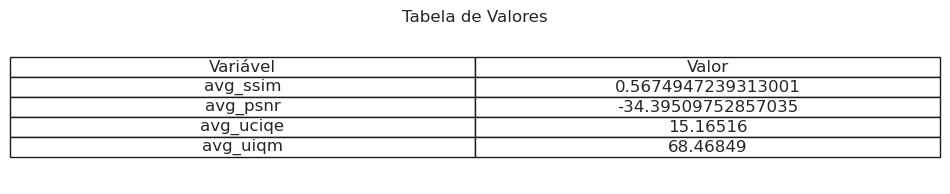

In [7]:
from pprint import pprint as pp
import matplotlib.pyplot as plt
import seaborn as sns
def extrair_valores(arquivo):
    # Dicionário para armazenar os valores das variáveis
    valores = {}

    # Abrindo o arquivo para leitura
    with open(arquivo, 'r') as f:
        for linha in f:
            # Dividindo a linha em nome da variável e valor
            variavel, valor = linha.split(':')
            # Removendo espaços em branco e convertendo o valor para float
            valores[variavel.strip()] = float(valor.strip())

    return valores

# Exemplo de uso
arquivo = 'output/Unet_metrics.txt'
valores_extraidos = extrair_valores(arquivo)
# pp(valores_extraidos)
# pp(valores_extraidos['avg_ssim'])

# Convertendo o dicionário em uma lista de listas para criar a tabela
dados = [[chave, valor] for chave, valor in valores_extraidos.items()]

pp(dados)

# Criando a figura e o eixo
fig, ax = plt.subplots(figsize=(10, len(dados) * 0.5))

# Ocultando o eixo
ax.axis('tight')
ax.axis('off')

# Criando a tabela usando matplotlib
tabela = ax.table(cellText=dados, colLabels=["Variável", "Valor"], cellLoc='center', loc='center')

# Ajustando a visualização
tabela.auto_set_font_size(False)
tabela.set_fontsize(12)
tabela.scale(1.2, 1.2)
plt.title("Tabela de Valores")
plt.show()

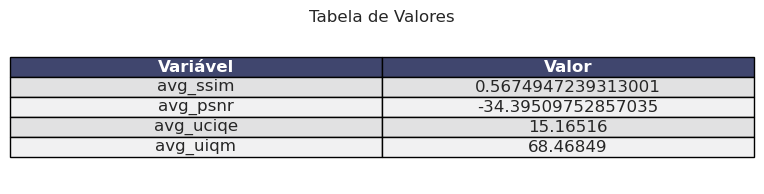

In [9]:
from pprint import pprint as pp
import matplotlib.pyplot as plt
import seaborn as sns

def extrair_valores(arquivo):
    # Dicionário para armazenar os valores das variáveis
    valores = {}

    # Abrindo o arquivo para leitura
    with open(arquivo, 'r') as f:
        for linha in f:
            # Dividindo a linha em nome da variável e valor
            variavel, valor = linha.split(':')
            # Removendo espaços em branco e convertendo o valor para float
            valores[variavel.strip()] = float(valor.strip())

    return valores

# Exemplo de uso
arquivo = 'output/Unet_metrics.txt'
valores_extraidos = extrair_valores(arquivo)

# Convertendo o dicionário em uma lista de listas para criar a tabela
dados = [[chave, valor] for chave, valor in valores_extraidos.items()]

# Definindo o estilo do seaborn
sns.set(style="whitegrid")

# Criando a figura e o eixo
fig, ax = plt.subplots(figsize=(8, len(dados) * 0.5))

# Ocultando o eixo
ax.axis('tight')
ax.axis('off')

# Criando a tabela usando matplotlib
tabela = ax.table(cellText=dados, colLabels=["Variável", "Valor"], cellLoc='center', loc='center')

# Ajustando a visualização
tabela.auto_set_font_size(False)
tabela.set_fontsize(12)
tabela.scale(1.2, 1.2)

# Estilizando a tabela
for (i, j), cell in tabela.get_celld().items():
    cell.set_edgecolor('black')
    if i == 0:
        cell.set_text_props(weight='bold', color='white')
        cell.set_facecolor('#40466e')
    else:
        cell.set_facecolor('#f1f1f2' if i % 2 == 0 else '#e1e1e2')

plt.title("Tabela de Valores")
plt.show()

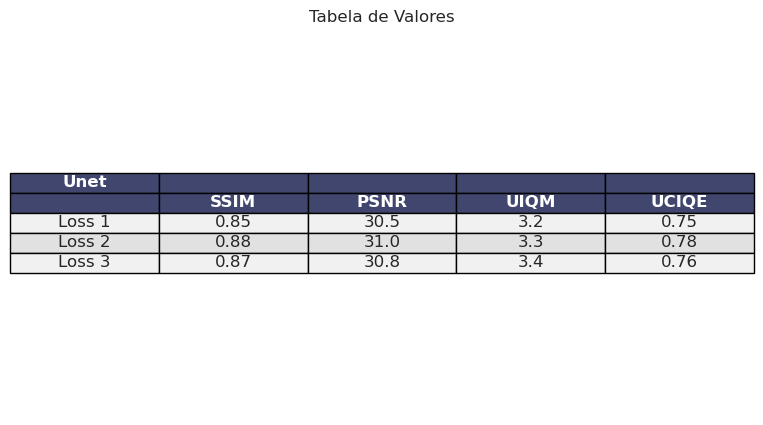

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Dados organizados em uma matriz
dados = [
    ["Unet", "", "", "", ""],
    ["", "SSIM", "PSNR", "UIQM", "UCIQE"],
    ["Loss 1", 0.85, 30.5, 3.2, 0.75],
    ["Loss 2", 0.88, 31.0, 3.3, 0.78],
    ["Loss 3", 0.87, 30.8, 3.4, 0.76]
]

# Definindo o estilo do seaborn
sns.set(style="whitegrid")

# Criando a figura e o eixo
fig, ax = plt.subplots(figsize=(8, 5))

# Ocultando o eixo
ax.axis('tight')
ax.axis('off')

# Criando a tabela usando matplotlib
tabela = ax.table(cellText=dados, cellLoc='center', loc='center')

# Ajustando a visualização
tabela.auto_set_font_size(False)
tabela.set_fontsize(12)
tabela.scale(1.2, 1.2)

# Estilizando a tabela
for (i, j), cell in tabela.get_celld().items():
    cell.set_edgecolor('black')
    if i == 0 or i == 1:
        cell.set_text_props(weight='bold', color='white')
        cell.set_facecolor('#40466e')
    else:
        cell.set_facecolor('#f1f1f2' if i % 2 == 0 else '#e1e1e2')

plt.title("Tabela de Valores")
plt.show()

In [ ]:
#Rede 1 - Unet # OBS: Salvar os dados resultantes em uma unica pasta de txt em vez de salvar junto com as imagens --> modificar codigo de avaliacao deo modelo
## Le os arquivos em uma pasta comum e extrai a rede a loss como informacao 
## acrescenta os valores em um dicionario
## plota um grafico com os valores para cada, metrica

##Fazer uma funcao que plote os valores no formato de linhas para o Latex


In [46]:
import matplotlib.pyplot as plt

def plotar_valores(dados):

    # Iterar sobre as redes e suas respectivas métricas
    for rede, metricas in dados.items():
        print(f"rede: {rede}")
        for loss, valores in metricas.items():
            # Extrair os valores das métricas
            ssim = valores.get('ssim', 0)
            psnr = valores.get('psnr', 0)
            uiqm = valores.get('uiqm', 0)
            uciqe = valores.get('uciqe', 0)

            # Criar o gráfico
            metricas = ['SSIM', 'PSNR', 'UIQM', 'UCIQE']
            valores = [ssim, psnr, uiqm, uciqe]

            print(f"""      loss: {loss}
                    ssim: {ssim} & psnr: {psnr} & uiqm: {uiqm} &  uciqe: {uciqe} // /hline    
            """)

# Exemplo de uso
dados = {
    'unet': {
        'perceptualloss1': {'ssim': 213, 'psnr': 30.5, 'uiqm': 8784, 'uciqe': 0.75},
        'perceptualloss2': {'ssim': 220, 'psnr': 31.0, 'uiqm': 8800, 'uciqe': 0.78},
        'perceptualloss3': {'ssim': 215, 'psnr': 30.8, 'uiqm': 8790, 'uciqe': 0.76}
    }
}

plotar_valores(dados)

rede: unet
      loss: perceptualloss1
                    ssim: 213 & psnr: 30.5 & uiqm: 8784 &  uciqe: 0.75 // /hline    
            
      loss: perceptualloss2
                    ssim: 220 & psnr: 31.0 & uiqm: 8800 &  uciqe: 0.78 // /hline    
            
      loss: perceptualloss3
                    ssim: 215 & psnr: 30.8 & uiqm: 8790 &  uciqe: 0.76 // /hline    
            


# Erro VAE Model


In [13]:
import torch
from models import VAE_model
# Inicialização do modelo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VAE_model().to(device)

# Gera um tensor randômico com formato (1, 3, 256, 256)
random_tensor = torch.randn(1, 3, 256, 256).to(device)
# Teste com tensor randômico
model.eval()
with torch.no_grad():
    
    
    # Passa o tensor randômico pelo encoder para obter mu e logvar
    mu, logvar = model.encoder(random_tensor)
    
    # Reamostragem para obter o vetor latente z
    z = model.reparameterize(mu, logvar)
    
    # Passa o vetor latente pelo decoder para gerar a imagem reconstruída
    generated_image, _, _ = model(random_tensor)
    
    print("Generated Image Shape:", generated_image.shape)  # Esperado: (1, 3, 256, 256)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x1024 and 4096x16)